# Convolutions for Images

## The Cross-Correlation Operation

In [2]:
!pip install d2l

In [3]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [4]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] * K))
    return Y


In [5]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[19., 25.],
       [37., 43.]], dtype=float32)>

## Convolutional Layers

In [6]:
class Conv2D(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, kernel_size):
        initializer = tf.random_normal_initializer()
        self.weight = self.add_weight(name='w', shape=kernel_size,
                                      initializer=initializer)
        self.bias = self.add_weight(name='b', shape=(1, ),
                                    initializer=initializer)

    def call(self, inputs):
        return corr2d(inputs, self.weight) + self.bias


## Object Edge Detection in Images

In [7]:
X = tf.Variable(tf.ones((6, 8)))
X[:, 2:6].assign(tf.zeros(X[:, 2:6].shape))
X


<tf.Variable 'Variable:0' shape=(6, 8) dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)>

In [8]:
K = tf.constant([[1.0, -1.0]])


In [9]:
Y = corr2d(X, K)
Y


<tf.Variable 'Variable:0' shape=(6, 7) dtype=float32, numpy=
array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]], dtype=float32)>

In [10]:
corr2d(tf.transpose(X), K)


<tf.Variable 'Variable:0' shape=(8, 5) dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

## Learning a Kernel

In [11]:
conv2d = tf.keras.layers.Conv2D(1, (1, 2), use_bias=False)


X = tf.reshape(X, (1, 6, 8, 1))
Y = tf.reshape(Y, (1, 6, 7, 1))
lr = 3e-2  

Y_hat = conv2d(X)
for i in range(10):
    with tf.GradientTape(watch_accessed_variables=False) as g:
        g.watch(conv2d.weights[0])
        Y_hat = conv2d(X)
        l = (abs(Y_hat - Y)) ** 2
        
        update = tf.multiply(lr, g.gradient(l, conv2d.weights[0]))
        weights = conv2d.get_weights()
        weights[0] = conv2d.weights[0] - update
        conv2d.set_weights(weights)
        if (i + 1) % 2 == 0:
            print(f'epoch {i + 1}, loss {tf.reduce_sum(l):.3f}')


epoch 2, loss 7.159
epoch 4, loss 2.573
epoch 6, loss 0.993
epoch 8, loss 0.397
epoch 10, loss 0.161


In [12]:
tf.reshape(conv2d.get_weights()[0], (1, 2))


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.9523919, -1.0349256]], dtype=float32)>

# Padding and Stride

## Padding

In [13]:
def comp_conv2d(conv2d, X):

    X = tf.reshape(X, (1, ) + X.shape + (1, ))
    Y = conv2d(X)

    return tf.reshape(Y, Y.shape[1:3])

conv2d = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same')
X = tf.random.uniform(shape=(8, 8))
comp_conv2d(conv2d, X).shape

TensorShape([8, 8])

In [14]:
conv2d = tf.keras.layers.Conv2D(1, kernel_size=(5, 3), padding='same')
comp_conv2d(conv2d, X).shape


TensorShape([8, 8])

## Stride

In [15]:
conv2d = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', strides=2)
comp_conv2d(conv2d, X).shape

TensorShape([4, 4])

In [16]:
conv2d = tf.keras.layers.Conv2D(1, kernel_size=(3,5), padding='valid',
                                strides=(3, 4))
comp_conv2d(conv2d, X).shape

TensorShape([2, 1])

# Multiple Input and Multiple Output Channels

## Multiple Input Channels

In [17]:
def corr2d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return tf.reduce_sum([d2l.corr2d(x, k) for x, k in zip(X, K)], axis=0)


In [18]:
X = tf.constant([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = tf.constant([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 56.,  72.],
       [104., 120.]], dtype=float32)>

## Multiple Output Channels

In [19]:
def corr2d_multi_in_out(X, K):

    return tf.stack([corr2d_multi_in(X, k) for k in K], 0)


In [20]:
K = tf.stack((K, K + 1, K + 2), 0)
K.shape


TensorShape([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)


<tf.Tensor: shape=(3, 2, 2), dtype=float32, numpy=
array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]], dtype=float32)>

## 1 x 1 Convolutional Layer

In [22]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = tf.reshape(X, (c_i, h * w))
    K = tf.reshape(K, (c_o, c_i))
   
    Y = tf.matmul(K, X)
    return tf.reshape(Y, (c_o, h, w))


In [24]:
X = tf.random.normal((3, 3, 3), 0, 1)
K = tf.random.normal((2, 3, 1, 1), 0, 1)

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(tf.reduce_sum(tf.abs(Y1 - Y2))) < 1e-6


# Pooling

## Maximum Pooling and Average Pooling

In [25]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = tf.Variable(tf.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w +1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j].assign(tf.reduce_max(X[i: i + p_h, j: j + p_w]))
            elif mode =='avg':
                Y[i, j].assign(tf.reduce_mean(X[i: i + p_h, j: j + p_w]))
    return Y


In [26]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[4., 5.],
       [7., 8.]], dtype=float32)>

In [27]:
pool2d(X, (2, 2), 'avg')


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

## Padding and Stride

In [28]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (1, 4, 4, 1))
X


<tf.Tensor: shape=(1, 4, 4, 1), dtype=float32, numpy=
array([[[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.]],

        [[ 4.],
         [ 5.],
         [ 6.],
         [ 7.]],

        [[ 8.],
         [ 9.],
         [10.],
         [11.]],

        [[12.],
         [13.],
         [14.],
         [15.]]]], dtype=float32)>

In [29]:
pool2d = tf.keras.layers.MaxPool2D(pool_size=[3, 3])
pool2d(X)


<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[10.]]]], dtype=float32)>

In [30]:
paddings = tf.constant([[0, 0], [1,0], [1,0], [0,0]])
X_padded = tf.pad(X, paddings, "CONSTANT")
pool2d = tf.keras.layers.MaxPool2D(pool_size=[3, 3], padding='valid',
                                   strides=2)
pool2d(X_padded)


<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 5.],
         [ 7.]],

        [[13.],
         [15.]]]], dtype=float32)>

In [31]:
paddings = tf.constant([[0, 0], [0, 0], [1, 1], [0, 0]])
X_padded = tf.pad(X, paddings, "CONSTANT")

pool2d = tf.keras.layers.MaxPool2D(pool_size=[2, 3], padding='valid',
                                   strides=(2, 3))
pool2d(X_padded)


<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 5.],
         [ 7.]],

        [[13.],
         [15.]]]], dtype=float32)>

## Multiple Channels

In [32]:
X = tf.concat([X, X + 1], 3)  

In [33]:
paddings = tf.constant([[0, 0], [1,0], [1,0], [0,0]])
X_padded = tf.pad(X, paddings, "CONSTANT")
pool2d = tf.keras.layers.MaxPool2D(pool_size=[3, 3], padding='valid',
                                   strides=2)
pool2d(X_padded)


<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
array([[[[ 5.,  6.],
         [ 7.,  8.]],

        [[13., 14.],
         [15., 16.]]]], dtype=float32)>

# Convolutional Neural Networks (LeNet)

## LeNet

In [34]:
import tensorflow as tf
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])


In [35]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


## Training

In [36]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)


4431872/4422102 [==============================] - 0s 0us/step


In [37]:
class TrainCallback(tf.keras.callbacks.Callback):  
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')


def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net


In [38]:
# yang eror hanya matplotlibnya yang tidak menampilkan gambar train loss, acc, test acc

loss 0.484, train acc 0.818, test acc 0.798
36997.4 examples/sec on /GPU:0


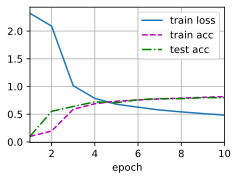

In [39]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
